#Import Libraries

In [54]:

import os
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
import matplotlib.pylab as plt
from matplotlib import interactive
from matplotlib.pyplot import figure
from google.colab import output
output.clear()
from matplotlib import cm

In [ ]:
#from colorspacious import cspace_converter

#Connect drive and set folders

In [55]:
from google.colab import drive
drive.mount('/content/drive',  force_remount = True)
output.clear()

In [56]:
save_dir = '/content/drive/MyDrive/22_GP_macad_CoolChairs/chair_interpolations/05_Training/2022-06-13_train/samples'
model_dir = '/content/drive/MyDrive/22_GP_macad_CoolChairs/chair_interpolations/05_Training/2022-06-13_train/tmp/generator_epoch_4001'

In [57]:
n_samples = 20

#Utils

In [80]:
def plot_samples(examples, n, name, use_treshold=True, threshold = 0.1, cube_dim=64,
                 show_graph = True, show_title = True, show_axis = False, save_fig=False, save_fig_dir=save_dir,
                 linewidths=0.01, figsize = pyplot.figaspect(1), dpi=80, cmap= 'plasma'):
  
  #fig = plt.figure(figsize=figsize)

  if examples.shape == (cube_dim,cube_dim,cube_dim):
    examples = examples.reshape(1,cube_dim,cube_dim,cube_dim)

  # plot images
  if use_treshold:
    examples = examples.reshape(( examples.shape[0],examples.shape[1],examples.shape[2],examples.shape[3] ))
    examples[examples<threshold] = 0

  
  fig = pyplot.figure(figsize = (20,20)) #fig = pyplot.figure(figsize=figsize, dpi=dpi)  #(figsize=pyplot.figaspect(0.10)) #plot size
  p = int(np.ceil( len(examples)/n))
  for i in range(len(examples)):
    # define subplot
    ax = fig.add_subplot(n, p, 1 + i, projection='3d')
    # turn off axis
    if not show_axis:
      pyplot.axis('off')
    #define x,y,z for the showcase:
    x, y, z = examples[i].nonzero()
    # add title
    if show_title:
      ax.set_title('Point '+str(i))
    # pyplot.subplot(111, )
    ax.set_xlim(0, cube_dim)
    ax.set_ylim(0, cube_dim)
    ax.set_zlim(0, cube_dim)
    c_values = examples[i][np.nonzero(examples[i])]
    ax.scatter(x, y, z, zdir ='z', c = -z, cmap = cmap,linewidths=linewidths)
    #ax.scatter(x, y, z, zdir ='z', c = -c_values, cmap = cmap,linewidths=linewidths)
    # ax.scatter(x, y, z, zdir ='z', c = x, cmap = cmap,linewidths=linewidths)
  # fig.colorbar(ax, ax=fig.ravel().tolist())

  if save_fig:
    save_name = save_fig_dir + '/' + name + '.png'
    save_fig_dir_clean = save_fig_dir.rstrip(os.path.basename(os.path.normpath(save_fig_dir)))
    if not os.path.exists(save_fig_dir_clean):
        os.makedirs(save_fig_dir_clean)
    pyplot.savefig(save_name)
    print('Image saved')   

  if show_graph:
    pyplot.show()
  #clear figure not to exceed ram
  if save_fig:
    pyplot.clf()

In [59]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

In [60]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=n_samples):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

In [61]:
# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = np.mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = np.vstack((vectors, avg_vector))
	return all_vectors

In [62]:
def ShowVoxelModel(voxels, figsize=(20, 20), axisoff=False, edgecolor = 'teal', facecolor='deepskyblue', alpha = 0.5, linewidth = 0.2, azim = 60, elev = 30):
    voxels = voxels
    
    fig = plt.figure(figsize=figsize)
    

    ax = plt.subplot(projection='3d')
    ax.set_proj_type('ortho')
    ax.voxels(voxels, 
    facecolor=facecolor,
    edgecolor=edgecolor,
    alpha = alpha,
    linewidth =linewidth)
    ax.view_init(elev=elev, azim=azim)
   
    if axisoff:
        ax.set_axis_off()


    plt.show()

#Load Model and initiate samples

In [93]:
# load model
model = load_model(model_dir)


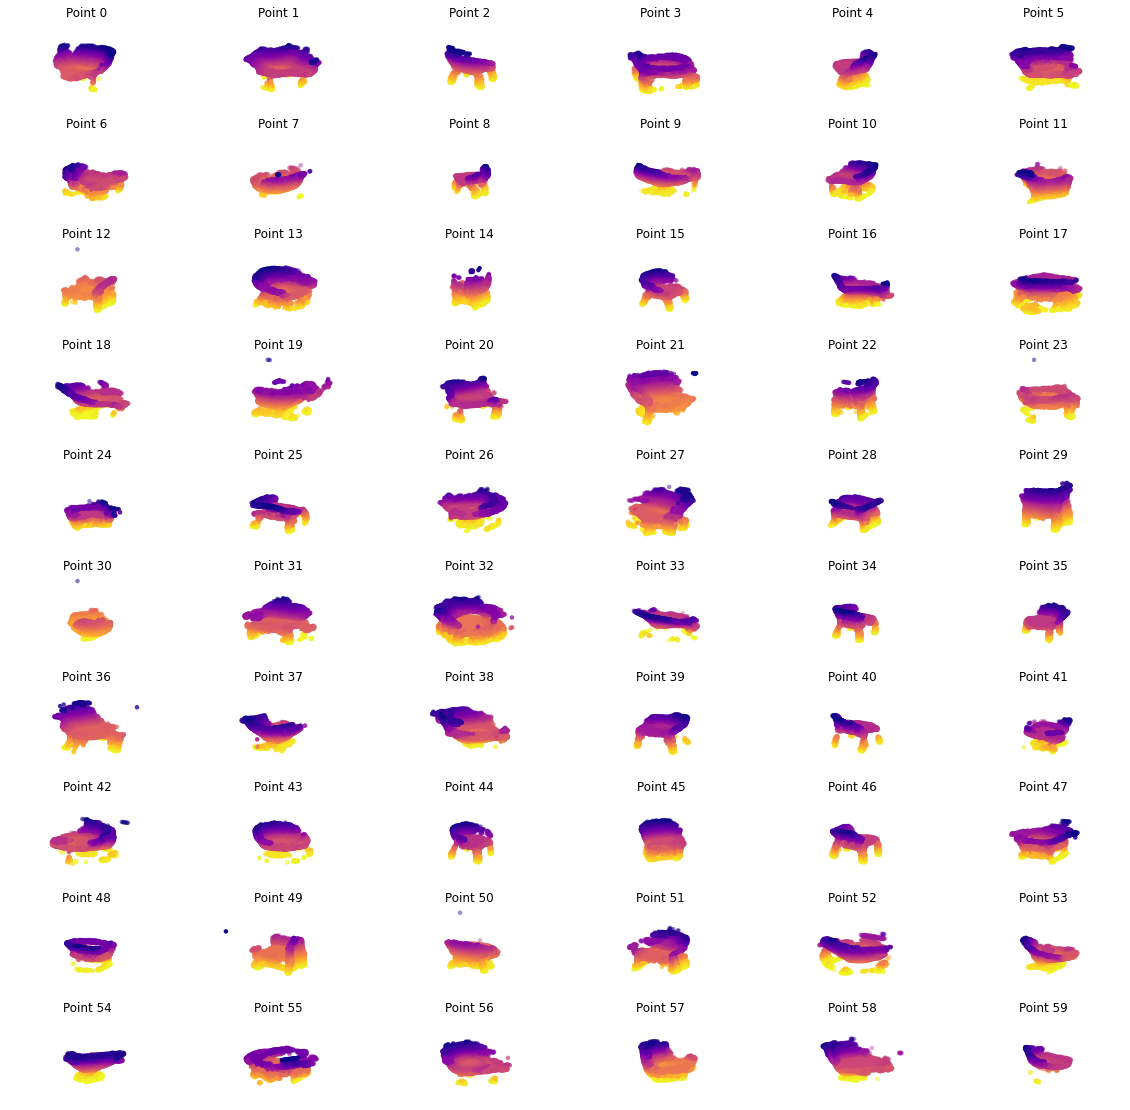

In [94]:
latent_points = generate_latent_points(100, 60)
# generate images
X  = model.predict(latent_points)


X = np.rint(X)

# plot the result
plot_samples(X, 10,'samples', save_fig=False)


#Interpolate between 2 points

16


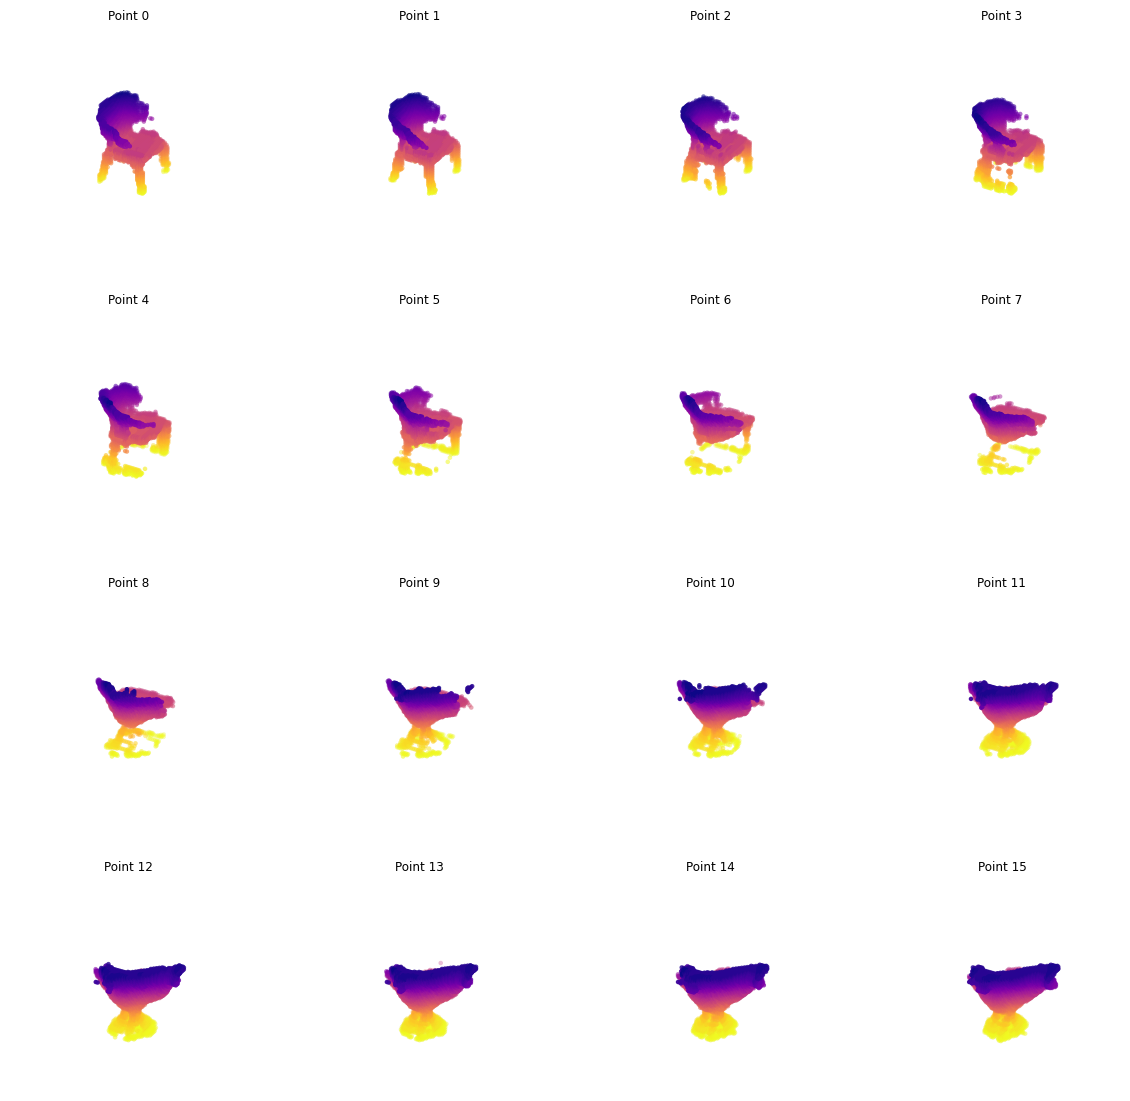

In [120]:
interpolated = interpolate_points(latent_points[15], latent_points[54], n_steps=16)
print (len(interpolated))

int_X  = model.predict(interpolated)


int_X = np.rint(int_X)

# plot the result
plot_samples(int_X, 4, name = "chair")

#Do vector arithmetic: Legs vs Organic

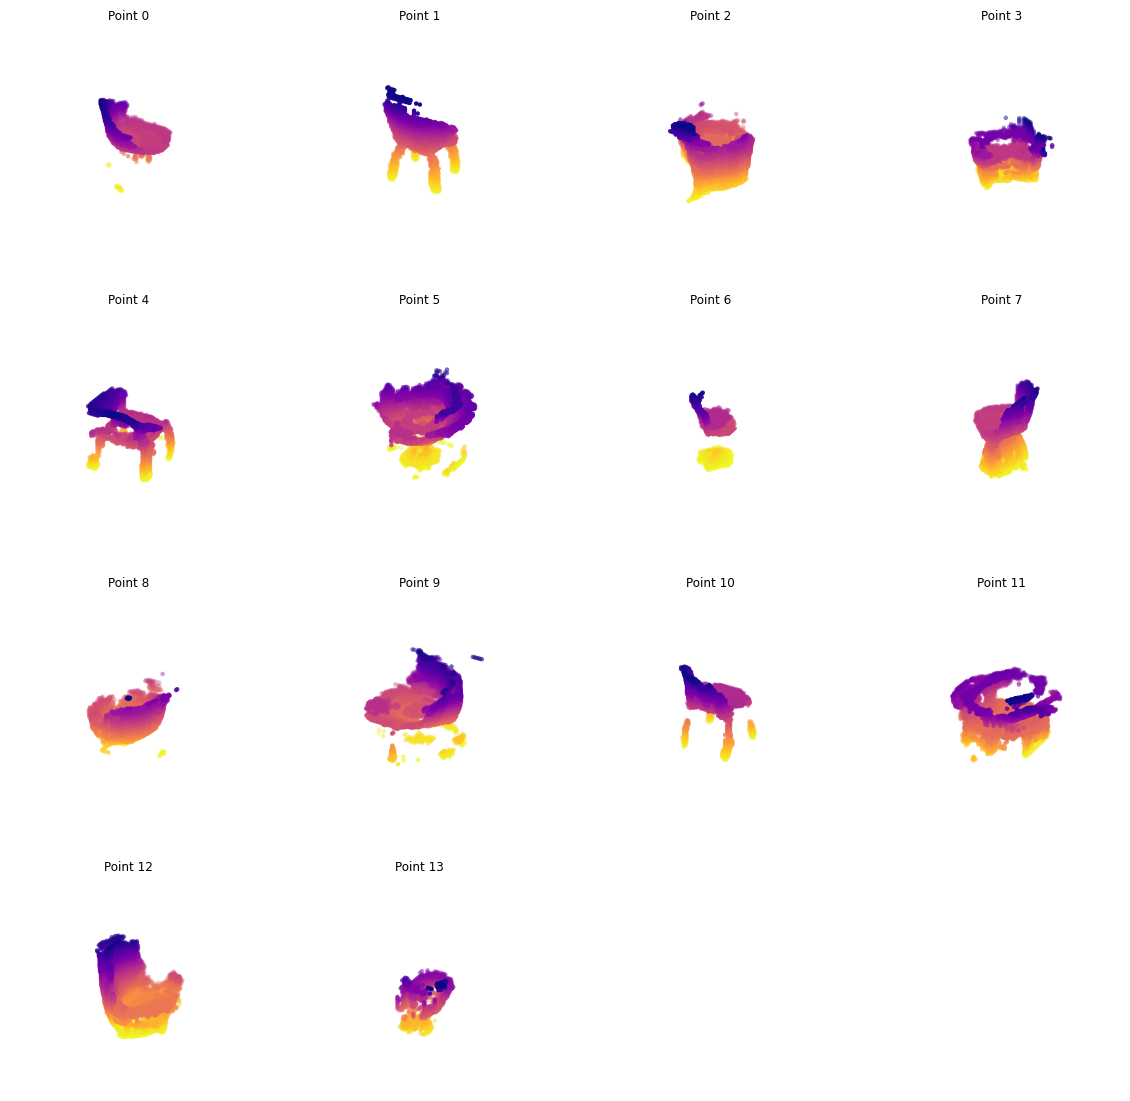

In [95]:
# retrieve specific points
legs_ix = [0, 3,12,25,26,27]
organic_ix = [5,8,43,41,56,58]

# load the saved latent points
points = latent_points
# average vectors
legs = average_points(points, legs_ix)
organic = average_points(points, organic_ix)

# combine all vectors

all_vectors = np.vstack((legs, organic))

all_image = model.predict(all_vectors)

all_image = np.rint(all_image)

plot_samples(all_image, 4, 'averages')

(1, 64, 64, 64)


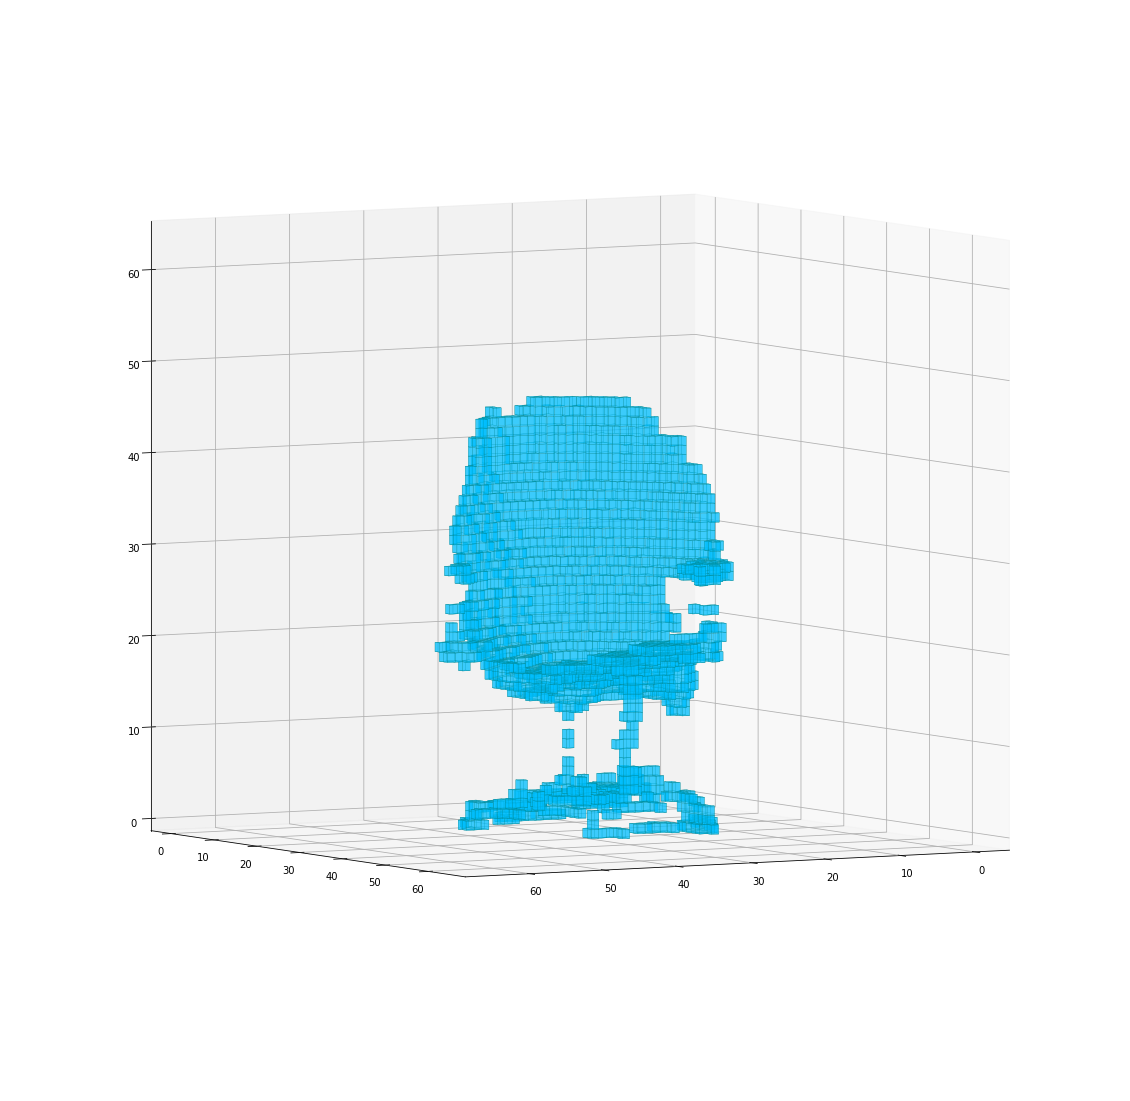

In [ ]:
# organic- legs
result_vector = organic[-1] - legs[-1] 
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
#plot_samples(result_image, 1)
result_image = result_image[:,:,:,:,-1]
print(result_image.shape)
ShowVoxelModel(result_image[0], elev = 5, azim= 60)

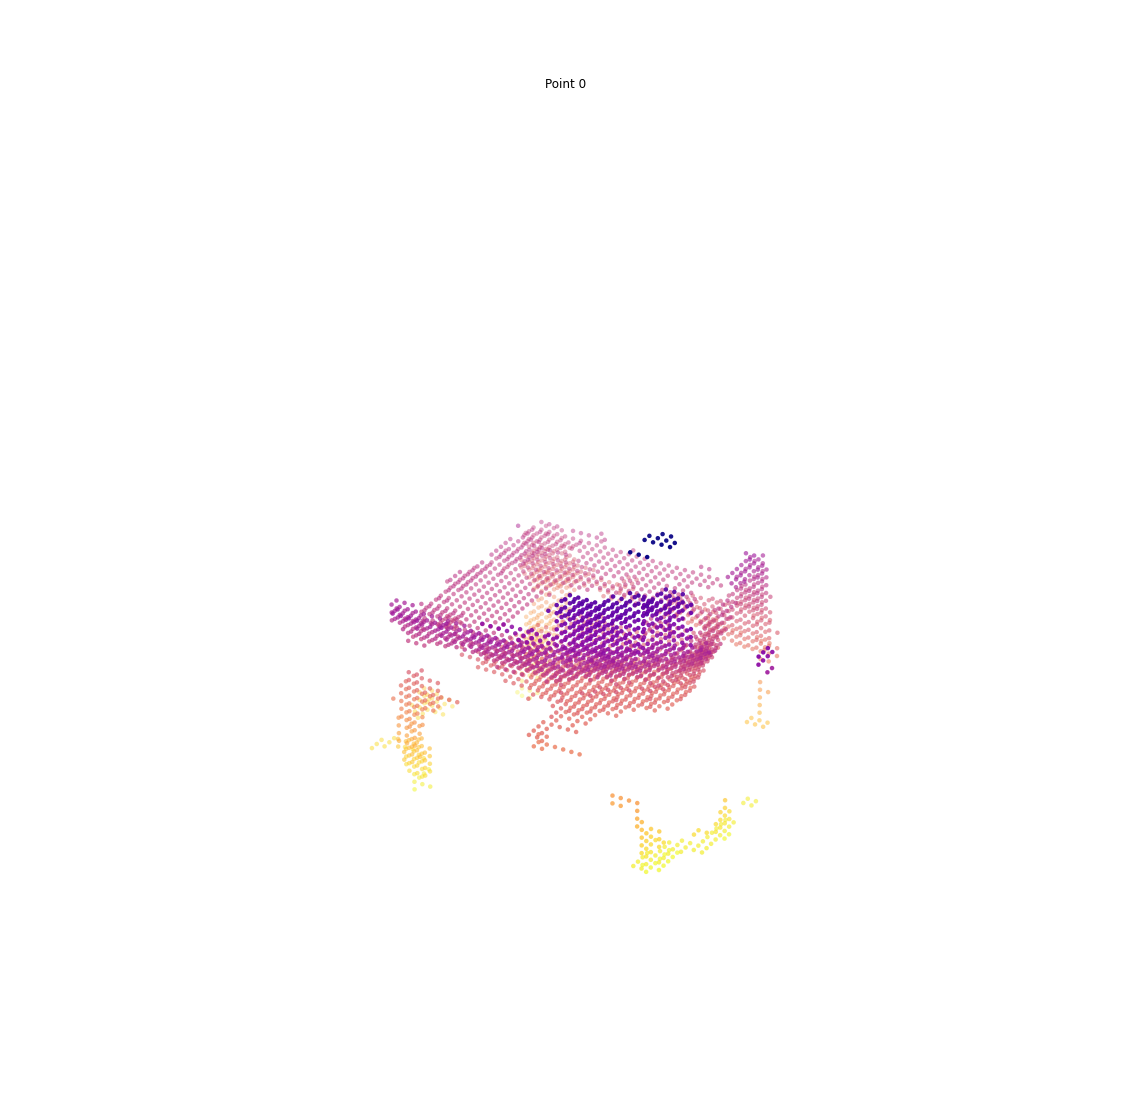

In [90]:
# organic- legs
result_vector = organic[-1] / legs[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")

# Backrest vs no backrest

In [96]:
# retrieve specific points
legs_ix = [6, 33,52,59,26,22]
organic_ix = [1,3,5,31,44,54]

# load the saved latent points
points = latent_points
# average vectors
legs = average_points(points, legs_ix)
organic = average_points(points, organic_ix)

# combine all vectors

all_vectors = np.vstack((legs, organic))

all_image = model.predict(all_vectors)

all_image = np.rint(all_image)

#plot_samples(all_image, 4, 'averages')

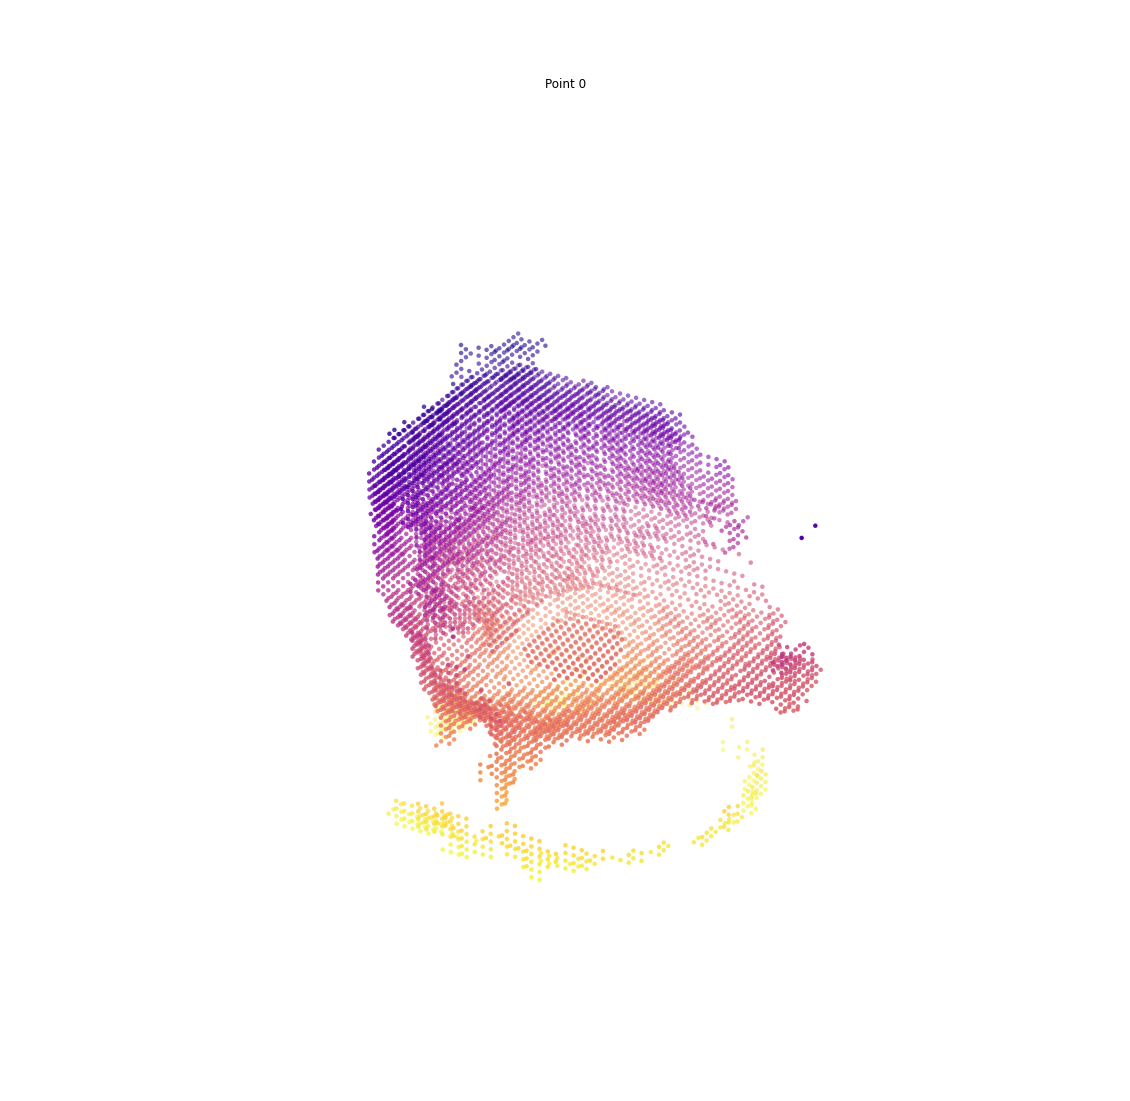

In [97]:
# organic- legs
result_vector = organic[-1] + legs[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")

In [98]:
# retrieve specific points
legs_ix = [17, 33,52,9,4,22]
organic_ix = [5,32,51,31,54,4]

# load the saved latent points
points = latent_points
# average vectors
legs = average_points(points, legs_ix)
organic = average_points(points, organic_ix)

# combine all vectors

all_vectors = np.vstack((legs, organic))

all_image = model.predict(all_vectors)

all_image = np.rint(all_image)

#plot_samples(all_image, 4, 'averages')

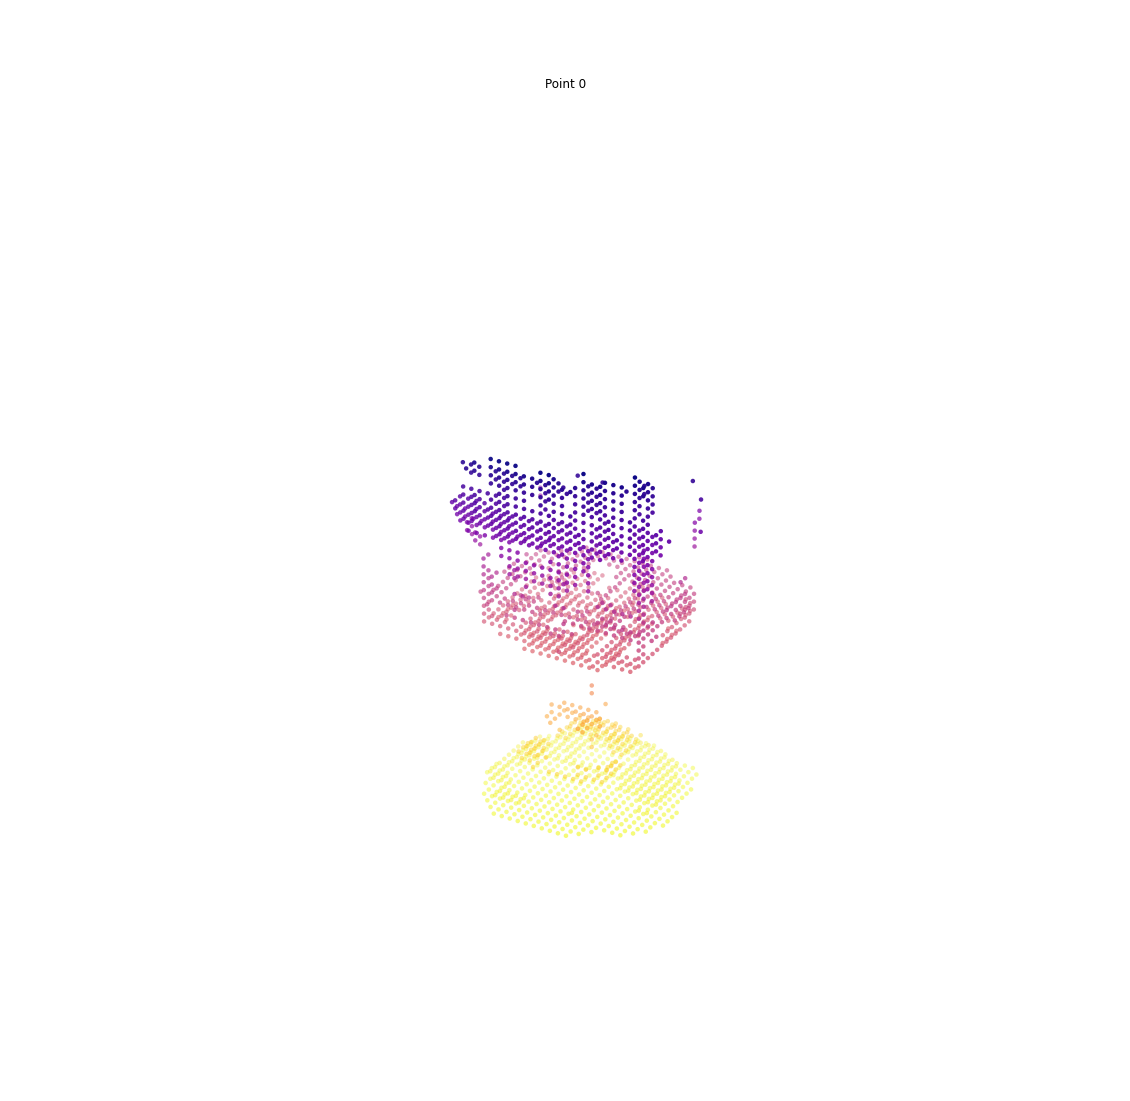

In [100]:
# organic- legs
result_vector = organic[-1] - legs[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")

In [101]:
# retrieve specific points
legs_ix = [1, 43,5,6,4,2]
organic_ix = [5,18,58,31,4,46]

# load the saved latent points
points = latent_points
# average vectors
legs = average_points(points, legs_ix)
organic = average_points(points, organic_ix)

# combine all vectors

all_vectors = np.vstack((legs, organic))

all_image = model.predict(all_vectors)

all_image = np.rint(all_image)

#plot_samples(all_image, 4, 'averages')

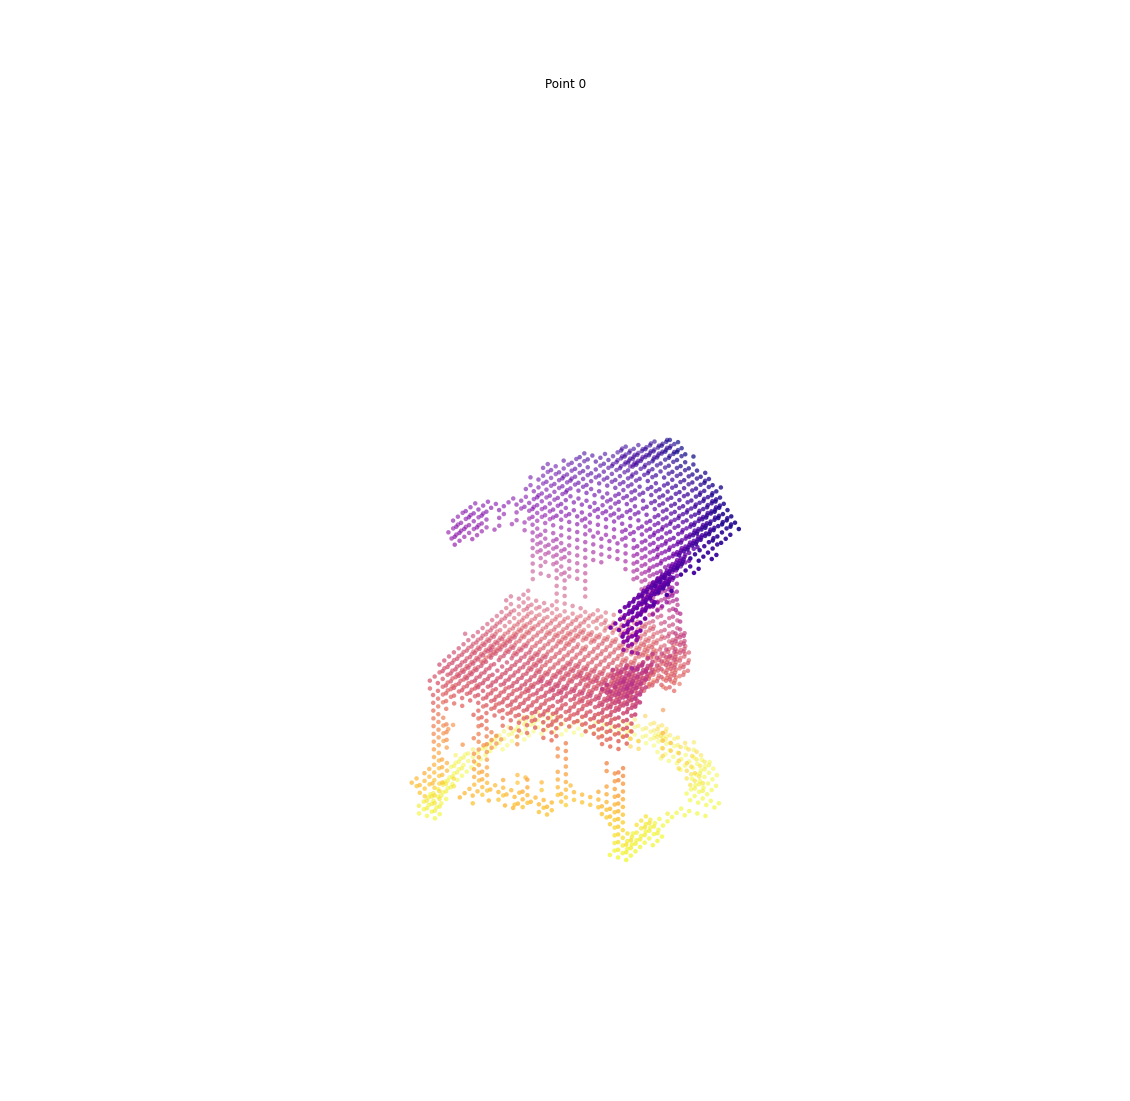

In [104]:
# organic- legs
result_vector =   legs[-1] - organic[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")

In [118]:
# retrieve specific points
legs_ix = [21, 42,31,11,40,19]
legs2_ix = [58,23,56,58,41,25]

# load the saved latent points
points = latent_points
# average vectors
legs = average_points(points, legs_ix)
legs2 = average_points(points, legs2_ix)

# combine all vectors

all_vectors = np.vstack((legs, organic))

all_image = model.predict(all_vectors)

all_image = np.rint(all_image)

#plot_samples(all_image, 4, 'averages')

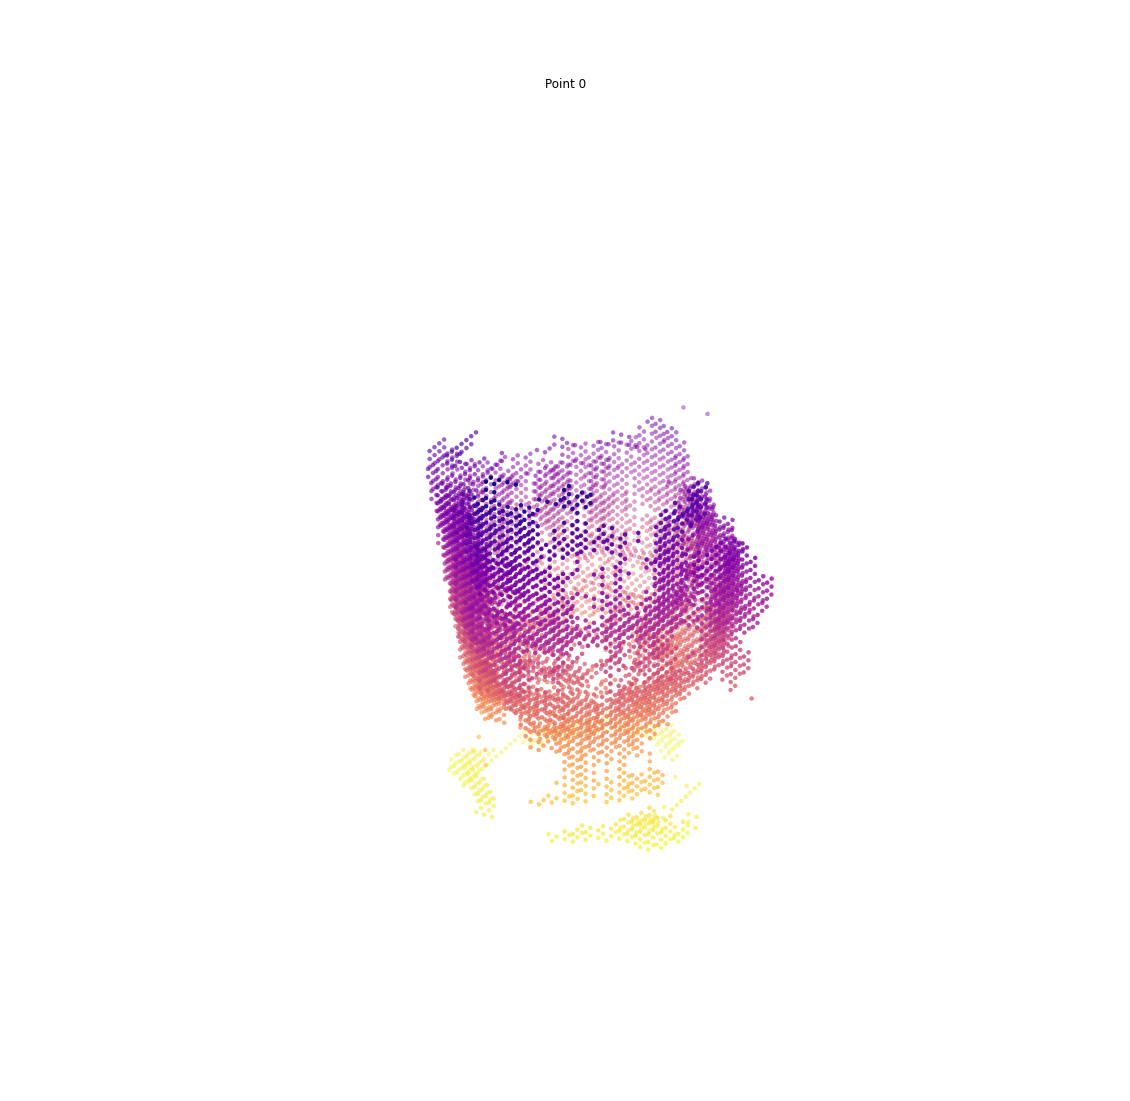

In [119]:
# organic- legs
result_vector = organic[-1] + legs[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")

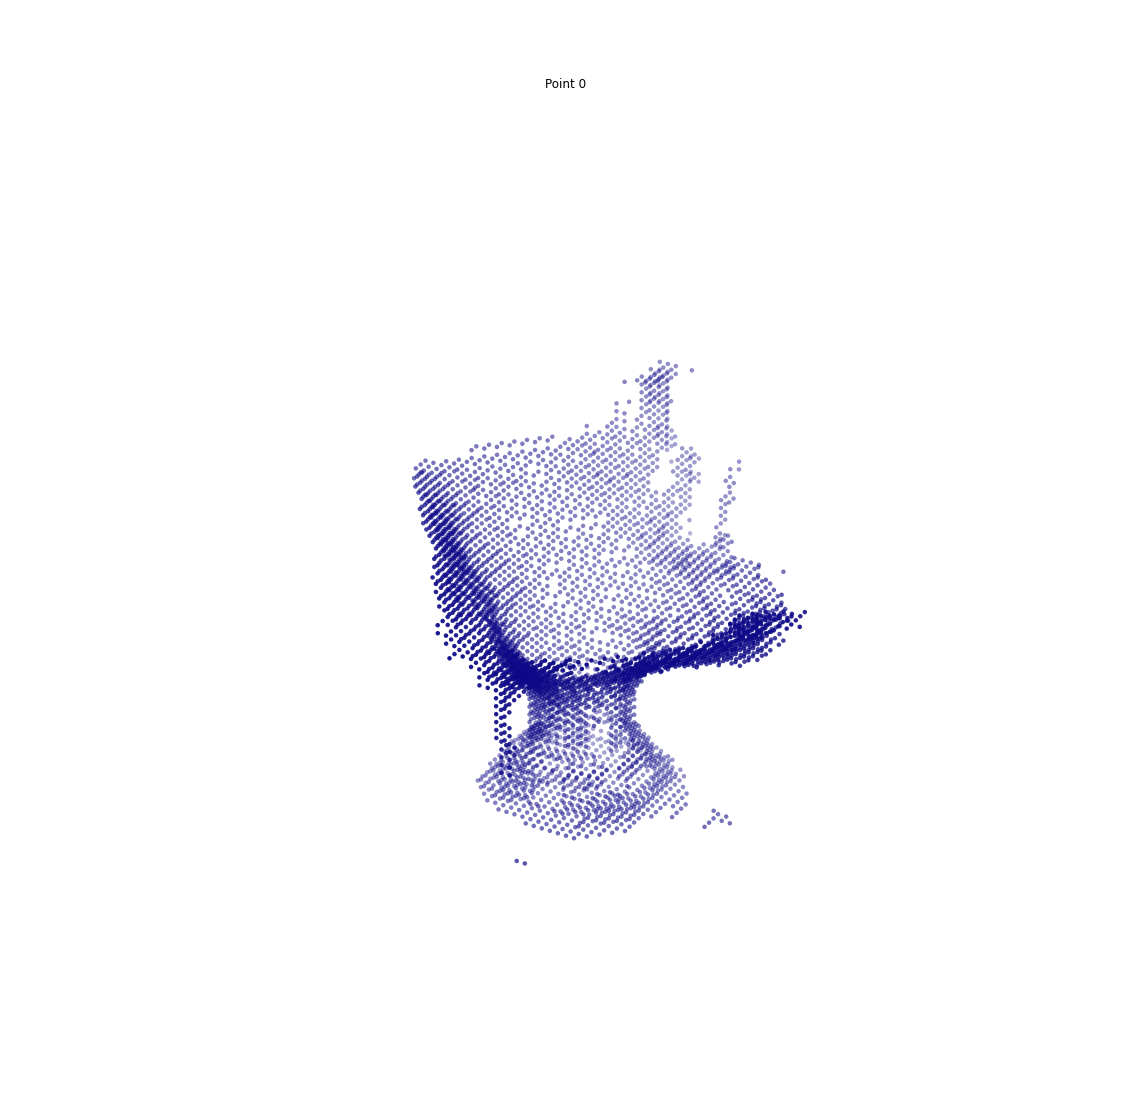

In [72]:
# 
result_vector = legs2[-1] - legs[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")

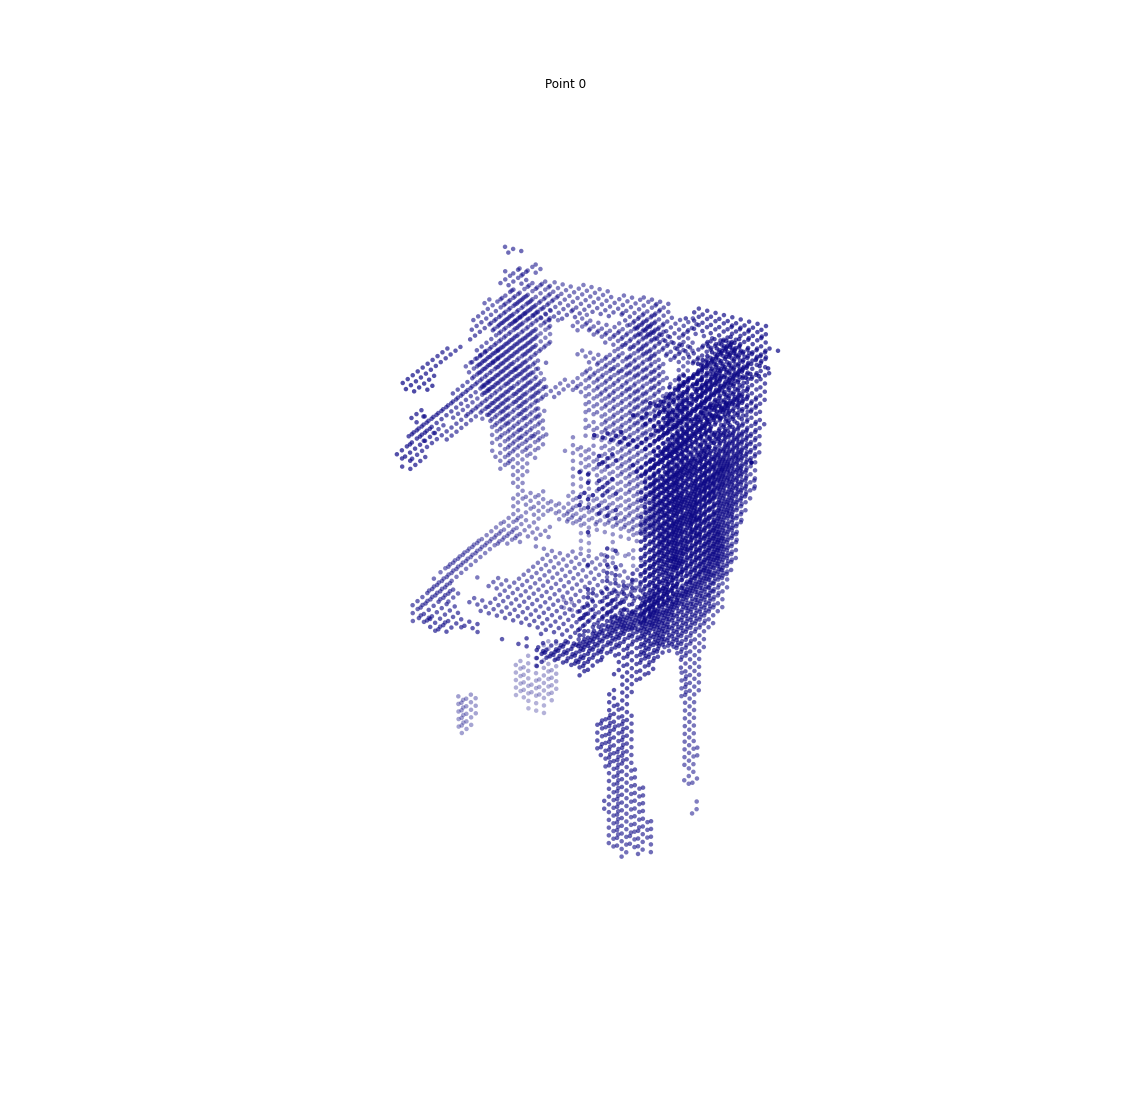

In [79]:
# 
result_vector =  legs[-1] / legs2[-1] 
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1, "chair")